# Sadržaj
1. Analitički model
2. Tensorflow usporedba
3. Usporedba analitičkog i tensorflow predviđanja za 2017. i 2018. godinu


## Učitavanje podataka

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc
from scipy.optimize import curve_fit

X = pd.read_csv("tas_1901_2016_HRV.csv")
X["T"] = 1901+X.index/12
months = pd.unique(X[' Month'])
X['Mj']=[i for x in X[' Month'] for i in range(12) if months[i]==x]

# 1. Analitički model
Kako bismo opisali ponašanje unutar godine, za svaki mjesec pretpostavljamo zasebni model.
Ako je $y$ varijabla godine, a $m$ mjeseca, temperaturu u mjesecu $m$, $T_m$ opisujemo najjednostavnijim anharmoničkim modelom
$$
T_m(y)=a_m+b_m y+c_m y^2+d_m y^3.
$$
Ovim modelom na jednostavan način možemo opisati efekte globalnog zagrijavanja s jedne strane i varijaciju temperature kroz mjesece u godini s druge.
Kako bismo mogli lakše provjeriti modele, pri određivanju parametara uzimamo samo vremenski interval $y<2006$, dok zadnjih deset godina mjerenja ostavljamo za test modela.

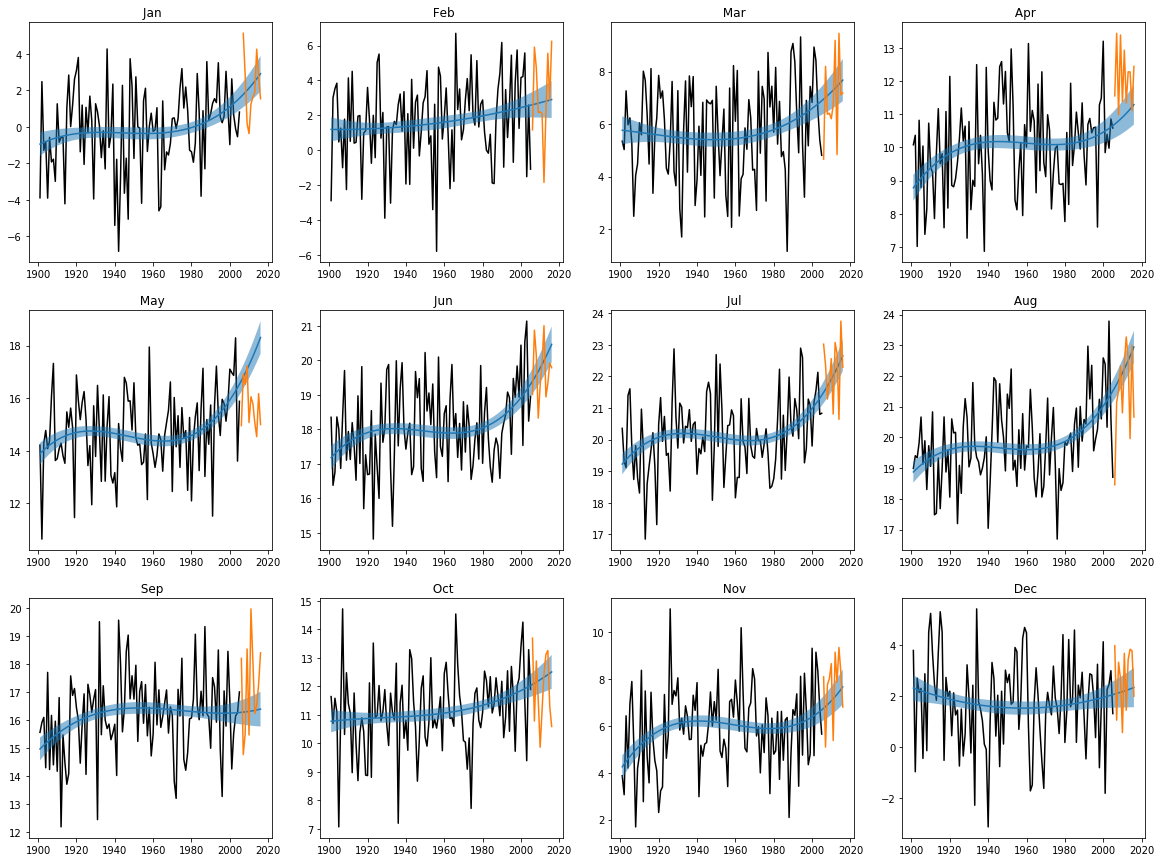

In [2]:

def model(t,a,b,c,d):
     return a+b*t+c*t**2+d*t**3
def model_err(t,S):
    J = np.zeros((4,t.size))
    J[0]=1.
    J[1]=t
    J[2]=t**2
    J[3]=t**3
    return np.sqrt(np.diag(np.einsum('ia,ij,jb->ab',J,S,J)))

f,ax = plt.subplots(3,4,figsize=(4*5,3*5))
ax = np.array(ax).flatten()
parameters = []
covariances = []

for i,M in enumerate(months):
    CUT  = X.loc[X[' Month']==M]
    FIT  = CUT[CUT['T']<2006]
    TEST = CUT[CUT['T']>2006]
    x = FIT[' Year'].values
    y = FIT['Temperature - (Celsius)'].values
    p, S = curve_fit(model,x,y,bounds=(3*[-np.inf]+[0.],4*[np.inf]))
    m = model(CUT[' Year'],*p)
    e = model_err(CUT[' Year'],S)
    parameters.append(p)
    covariances.append(S)
    
    ax[i].plot(x,y,'k',zorder=0)
    ax[i].plot(CUT[' Year'],m,zorder=1)
    ax[i].fill_between(CUT[' Year'],m-e,m+e,alpha=0.5)
    ax[i].plot(TEST[' Year'],TEST['Temperature - (Celsius)'])
    ax[i].set_title(M)


## 1.1 Analiza reziduala
Na sljedećoj je slici prikazano ponašanje reziduala za sve mjesece kroz godine. Crvena linija prikazuje $1\sigma$ pogrešku prilagodbi. 

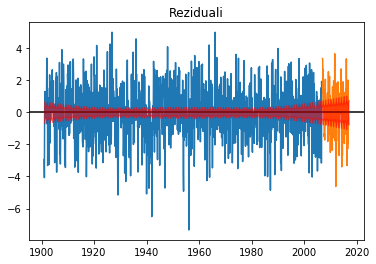

In [3]:

def puni_model(t,i,P):
    o = []
    for j in range(len(t)):
        o.append(model(t[j],*P[i[j]]))
    return o
def puni_model_err(t,i,S):
    o = []
    for j in range(len(t)):
        o.append(model_err(t[j],S[i[j]])[0])
    return o
X['Model 1'] = puni_model(X[' Year'],X['Mj'],parameters)
X['Model 1 err'] = puni_model_err(X[' Year'],X['Mj'],covariances)
X['R 1'] = X['Temperature - (Celsius)']-X['Model 1']
plt.plot(X['T'][:-10*12],X['R 1'][:-10*12])
plt.plot(X['T'][-10*12:],X['R 1'][-10*12:])
plt.fill_between(X['T'],X['Model 1 err'],-X['Model 1 err'],alpha=.5,color='r',zorder=10)
plt.axhline(0,color='k')
plt.title('Reziduali');

Također, KS testom testiramo prate li reziduali za $y<2006$ i $y>2006$ normalne distribucije.
Rezultat ovog testa je da se hipoteza normalnosti ne može odbaciti u oba slučaja, te da su također u oba slučaja reziduali centrirani na 0.
Desni dijagram prikazuje ponašanje reziduala za zasebno za svaki mjesec.

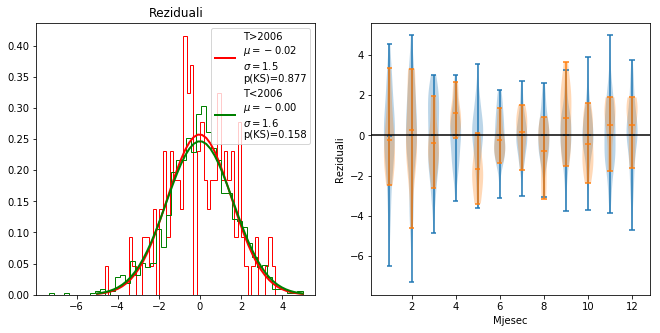

In [4]:
f,ax=plt.subplots(1,2,figsize=(11,5))
cut = X['T']>2006
A   = X.loc[cut]
ax[0].hist(A['R 1'],50,density=True,histtype='step',color='r',label=None)
pars = sc.norm.fit(A['R 1'])
N = sc.norm(*pars)
ks = sc.kstest(A['R 1'],N.cdf)[1]
ax[0].plot(np.linspace(-5,5),N.pdf(np.linspace(-5,5)),color='r',lw=2,
        label='T>2006\n$\mu=%.2f$\n$\sigma=%.1f$\np(KS)=%.3f'%(pars[0],pars[1],ks))
B   = X.loc[~cut]
ax[0].hist(B['R 1'],50,density=True,histtype='step',color='g',label=None)
pars = sc.norm.fit(B['R 1'])

N = sc.norm(*pars)
ks = sc.kstest(B['R 1'],N.cdf)[1]
ax[0].plot(np.linspace(-5,5),N.pdf(np.linspace(-5,5)),color='g',lw=2,
       label='T<2006\n$\mu=%.2f$\n$\sigma=%.1f$\np(KS)=%.3f'%(pars[0],pars[1],ks))
ax[0].legend()
ax[0].set_title('Reziduali');
ax[1].violinplot([B["R 1"][B["Mj"]==m].values for m in np.arange(12)],showmeans=True)
ax[1].violinplot([A["R 1"][A["Mj"]==m].values for m in np.arange(12)],showmeans=True)
ax[1].axhline(0,color='k')
ax[1].set_xlabel("Mjesec")
ax[1].set_ylabel("Reziduali");

## 1.2 Usporedba s izmjerenim temperaturama
Na sljedećoj je slici prikazana usporedba srednjih temperatura za svaki mjesec ( i pripadna standarda devijacija uzorka), označenih crnim točkama, i modela s $2\sigma$ intervalom pouzdanosti.
Vidimo da model dobro opisuje ponašanje za sve mjesece, uz veća odstupanja za zimske mjesece

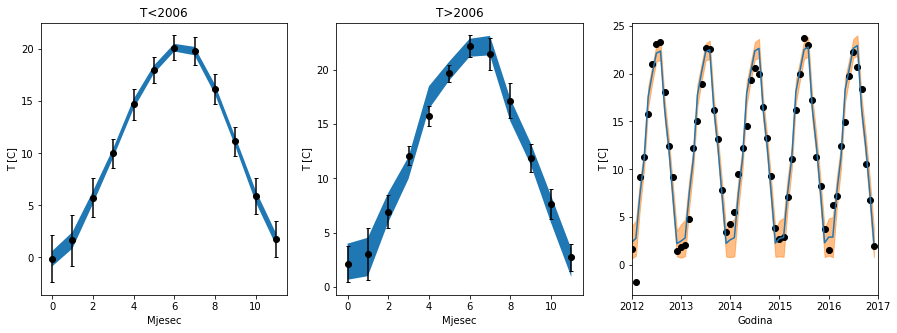

In [5]:
A = X[X['T']<2006]
B = X[X['T']>2006]
Y = A.groupby(A[' Month']).mean()
Z = A.groupby(A[' Month']).std()
Y.index=pd.CategoricalIndex(Y.index,  categories=months, )
Z.index=pd.CategoricalIndex(Z.index,  categories= months,  )
Y=Y.sort_index()
Z=Z.sort_index()
f,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].errorbar(Y['Mj'],Y['Temperature - (Celsius)'],Z['Temperature - (Celsius)'],fmt='ko',capsize=2)
ax[0].fill_between(Y['Mj'],Y['Model 1']-2*Y['Model 1 err'],Y['Model 1']+2*Y['Model 1 err'])

Y = B.groupby(B[' Month']).mean()
Z = B.groupby(B[' Month']).std()
Y.index=pd.CategoricalIndex(Y.index,  categories=months, )
Z.index=pd.CategoricalIndex(Z.index,  categories= months,  )
Y=Y.sort_index()
Z=Z.sort_index()
ax[1].errorbar(Y['Mj'],Y['Temperature - (Celsius)'],Z['Temperature - (Celsius)'],fmt='ko',capsize=2)
ax[1].fill_between(Y['Mj'],Y['Model 1']-2*Y['Model 1 err'],Y['Model 1']+2*Y['Model 1 err'])
ax[0].set_title('T<2006')
ax[1].set_title('T>2006')
for a in ax:
    a.set_xlabel('Mjesec')
    a.set_ylabel('T [C]')

ax[2].plot(B['T'],B['Temperature - (Celsius)'],'ko')
ax[2].plot(B['T'],B['Model 1'],label='Model 1')
ax[2].fill_between(B['T'],B['Model 1']-2*B['Model 1 err'],B['Model 1']+2*B['Model 1 err'],color='C1',alpha=0.5)
ax[2].set_xlim(2012,2017)
ax[2].set_xlabel('Godina');

## 1.3 Usporedba s predviđanjima svjetske banke za naredno desetljeće
Predviđanja se mogu usporediti i s modelom za sljedeće desetljeće.  Model dobro predviđa temperature ljetnih mjeseci, a podcjenuje temperature veljače i prosinca 

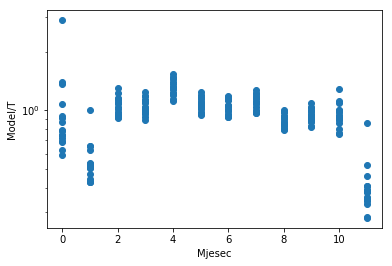

In [35]:

Xpred = pd.read_csv("tas_2020_2039_mavg_rcp26_HRV.csv")
mj = pd.unique(Xpred[' Statistics'])
Xpred['Mj']=[i for x in Xpred[' Statistics'] for i in range(len(mj)) if mj[i]==x]
Xpred['T'] = Xpred.index/12.+2020.
Xpred['Year'] = Xpred.index//12+2020
Xpred['Model 1'] = puni_model(Xpred['Year'],Xpred['Mj'],parameters)
Xpred['Residual'] = Xpred['Monthly Temperature - (Celsius)']-Xpred['Model 1']
plt.xlabel("Mjesec")
plt.ylabel("Model/T")
plt.plot(Xpred['Mj'],Xpred['Model 1']/Xpred['Monthly Temperature - (Celsius)'],'o')
plt.yscale('log')
plt.axhline(color="c");

Sveukupno, model nema značajna statistička odstupanja niti za predviđanja (reziduali centrirani na 0, KS-test ne ukazuje na odstupanja od normalne distribucije)

KS s normalnom distribucijom, p= 0.6494721120696274
(mu,sigma)= (0.10327979956246518, 2.785770392586694)


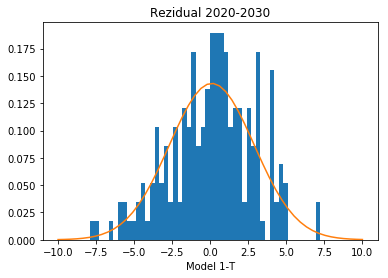

In [40]:
plt.hist(Xpred['Residual'],50,density=True)
N = sc.norm(*sc.norm.fit(Xpred['Residual']))
plt.plot(np.linspace(-10,10),N.pdf(np.linspace(-10,10)))
print("KS s normalnom distribucijom, p=", sc.kstest(Xpred['Residual'],N.cdf)[1])
print("(mu,sigma)=",sc.norm.fit(Xpred['Residual']));
plt.title("Rezidual 2020-2030")
plt.xlabel("Model 1-T");

## 1.4 Predviđanja za 2017. i 2018. godinu

In [41]:
for y in [2017,2018]:
    for i in range(12):
        print(y,months[i], 
              "%.1f+/-%.1f"%(puni_model([y],[i],parameters)[0],
                             puni_model_err(np.array([2019]),[i],covariances)[0]))

2017  Jan 3.1+/-1.1
2017  Feb 2.9+/-1.2
2017  Mar 7.8+/-0.9
2017  Apr 11.4+/-0.7
2017  May 18.5+/-0.7
2017  Jun 20.6+/-0.6
2017  Jul 22.8+/-0.5
2017  Aug 23.1+/-0.6
2017  Sep 16.4+/-0.7
2017  Oct 12.6+/-0.7
2017  Nov 7.8+/-0.8
2017  Dec 2.4+/-0.9
2018  Jan 3.2+/-1.1
2018  Feb 3.0+/-1.2
2018  Mar 7.8+/-0.9
2018  Apr 11.4+/-0.7
2018  May 18.7+/-0.7
2018  Jun 20.7+/-0.6
2018  Jul 22.9+/-0.5
2018  Aug 23.3+/-0.6
2018  Sep 16.4+/-0.7
2018  Oct 12.6+/-0.7
2018  Nov 7.9+/-0.8
2018  Dec 2.4+/-0.9


# 2. Tensorflow usporedba
Za usporedbu je dan model napravljen pomoću tensorflow regresije. Iz histograma se vidi da model jednako dobro predviđa podatke kao i analitički model.

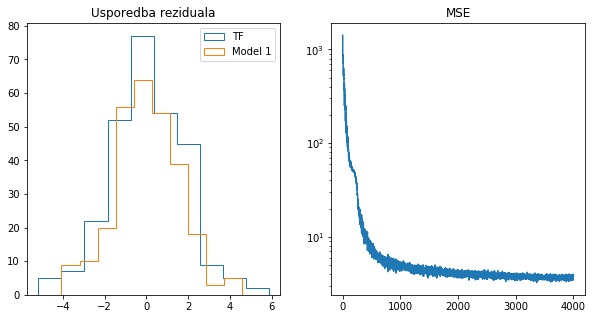

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
train        = X.sample(frac=0.8)
test         = X.drop(train.index)
train_labels = train["Temperature - (Celsius)"]
train_data   = train[[" Year", "Mj"]]
test_labels  = test["Temperature - (Celsius)"]
test_data    = test[[" Year", "Mj"]]

modelTF = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[2]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])
optimizer = tf.keras.optimizers.RMSprop(0.001)
modelTF.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 
                         'mean_squared_error'])
history = modelTF.fit(train_data, 
                    train_labels,
                    epochs=4000, 
                    validation_split = 0.2, 
                    verbose=0)
history = pd.DataFrame(history.history)
comparison=test.copy()
comparison['TF']=modelTF.predict(test_data).flatten()
comparison['Temp']=test_labels
comparison['R 2']=comparison['Temp']-comparison['TF']
X['TF']=modelTF.predict(X[[" Year", "Mj"]]).flatten()
f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].hist(comparison['R 2'],histtype='step',label='TF')
ax[0].hist(test['R 1'],histtype='step',label='Model 1')
ax[0].legend();
ax[1].plot(history.index,history['mean_squared_error'])
ax[1].set_title('MSE')
ax[1].set_yscale('log')
ax[0].set_title('Usporedba reziduala');

# 3. Usporedba analitičkog i tensorflow predviđanja za 2017. i 2018. godinu
Za većinu mjeseci, predikcije analitičkog modela i TF-a se slažu unutar unutar $\leq5\sigma$

In [42]:
predikcije=pd.DataFrame({'Godina':[],'Mjesec':[],
                         'TF':[],'Model 1':[],'Model 1 $\sigma$':[],"Razlika":[], 
                         "Značajnost odstupanja (u $\sigma$)":[]})
for y in [2017,2018]:
    for i in range(12):
        PM = puni_model([y],[i],parameters)[0]
        PMe = puni_model_err(np.array([2019]),[i],covariances)[0]
        TF = modelTF.predict(pd.DataFrame({' Year':[y],'Mj':[i]}))[0,0]
        TFR=TF-PM
        sigma=np.abs(TFR)/PMe
        predikcije=predikcije.append(pd.DataFrame({'Godina':[y],
                                                   'Mjesec':[months[i]],
                                                   'TF':[TF],
                                                   'Model 1':[PM],
                                                   'Model 1 $\sigma$':[PMe],
                                                   "Razlika":[TFR], 
                                                   "Značajnost odstupanja (u $\sigma$)":[sigma]}),
                                    ignore_index=True)
predikcije

,Godina,Mjesec,TF,Model 1,Model 1 $\sigma$,Razlika,Značajnost odstupanja (u $\sigma$)
0,2017.0,Jan,0.569887,3.057296,1.074225,-2.487408,2.315537
1,2017.0,Feb,2.279433,2.939703,1.163598,-0.660270,0.567438
2,2017.0,Mar,6.457793,7.758610,0.893355,-1.300817,1.456102
3,2017.0,Apr,10.706215,11.362488,0.663602,-0.656273,0.988955
4,2017.0,May,15.207453,18.506684,0.688454,-3.299231,4.792232
5,2017.0,Jun,18.929575,20.589846,0.572665,-1.660271,2.899200
6,2017.0,Jul,20.901203,22.795152,0.545074,-1.893949,3.474661
7,2017.0,Aug,20.864866,23.099669,0.588702,-2.234803,3.796150
8,2017.0,Sep,16.588177,16.407350,0.688050,0.180826,0.262810
9,2017.0,Oct,11.770119,12.555568,0.659544,-0.785450,1.190897
